# Overview
H&M recsys challenge 

Main page of the challenge: \
https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/overview

H&M Group is a family of brands and businesses with 53 online markets and approximately 4,850 stores. Our online store offers shoppers an extensive selection of products to browse through. But with too many choices, customers might not quickly find what interests them or what they are looking for, and ultimately, they might not make a purchase. To enhance the shopping experience, product recommendations are key. More importantly, helping customers make the right choices also has a positive implications for sustainability, as it reduces returns, and thereby minimizes emissions from transportation.

In this competition, H&M Group invites you to develop product recommendations based on data from previous transactions, as well as from customer and product meta data. The available meta data spans from simple data, such as garment type and customer age, to text data from product descriptions, to image data from garment images.

There are no preconceptions on what information that may be useful – that is for you to find out. If you want to investigate a categorical data type algorithm, or dive into NLP and image processing deep learning, that is up to you.

Submissions are evaluated according to the Mean Average Precision @ 12 (MAP@12)
I can share a great tutorial about this metric. \
https://www.kaggle.com/code/debarshichanda/understanding-mean-average-precision


# Общее описание 
H&M recsys challenge 

Главная страница задачи: \
https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/overview

H&M Group - это семейство брендов и предприятий, включающее 53 онлайн-маркета и около 4850 магазинов. Наш интернет-магазин предлагает покупателям широкий выбор товаров. Но при слишком большом выборе покупатели могут не сразу найти то, что их интересует или что они ищут, и в итоге могут не совершить покупку. Чтобы улучшить впечатления от покупок, рекомендации по товарам играют ключевую роль. Более того, помощь покупателям в правильном выборе также положительно сказывается на экологичности, поскольку сокращает количество возвратов и тем самым минимизирует выбросы при транспортировке.

В этом конкурсе H&amp;M Group предлагает вам разработать товарные рекомендации на основе данных о предыдущих транзакциях, а также метаданных о покупателях и товарах. Доступные метаданные включают в себя как простые данные, такие как тип одежды и возраст покупателя, так и текстовые данные из описаний товаров, а также данные из изображений одежды.

Нет никаких предубеждений относительно того, какая информация может быть полезной - это вы должны выяснить сами. Если вы хотите исследовать алгоритм категориального типа данных или погрузиться в глубокое обучение НЛП и обработке изображений - дело ваше.

Присылаемые материалы оцениваются по показателю средней точности @ 12 (MAP@12)
Я могу поделиться отличным руководством по этой метрике.
https://www.kaggle.com/code/debarshichanda/understanding-mean-average-precision


# Libraries

In [1]:
!pip install --upgrade implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 74.0 MB/s eta 0:00:00:00:010:01


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error

from scipy.sparse import coo_matrix, csr_matrix
import implicit
import time
from tqdm import tqdm
from implicit.als import AlternatingLeastSquares


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.4f}'.format)

# Loading dataset

In [3]:
base_path = '/kaggle/input/h-and-m-personalized-fashion-recommendations/'
csv_transactions = f'{base_path}transactions_train.csv'
csv_sample_submission = f'{base_path}sample_submission.csv'
csv_customers = f'{base_path}customers.csv'
csv_articles = f'{base_path}articles.csv'

df_transactions = pd.read_csv(csv_transactions, dtype={'article_id': str}, parse_dates=['t_dat'])
df_sample_submission = pd.read_csv(csv_sample_submission)
df_customers = pd.read_csv(csv_customers)
df_articles = pd.read_csv(csv_articles, dtype={'article_id': str})

# EDA

In [4]:
df_transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.0508,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.0305,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.0152,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.0169,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.0169,2


In [5]:
df_sample_submission.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...


In [6]:
df_customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0000,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0000,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0000,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0000,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0000,1.0000,ACTIVE,Regularly,52.0000,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [7]:
df_articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


First, I suggest a better understanding of the data and past buying behavior. How data is distributed in general and what characterizes their behavior. 

Important tip
sales_channel_id=1: Sales of ONLINE, 2: Sales of OFFLINE

Let's deal with the following parts \
Customer \
Article \
Transaction


Сначала предлагаю лучше понять данные и прошлое поведение покупателей. Как вообще распределены данные и что характеризует их поведение. 

Важное замечание
sales_channel_id=1: Продажи ONLINE, 2: Продажи OFFLINE

Разберемся со следующими частями \
Клиент \
Статья \
Транзакция

In [8]:
print(f"Number of rows and columns of sample submission: {df_customers.shape}")
print(f"Number of rows and columns of articles: {df_articles.shape,}")
print(f"Number of rows and columns of users: {df_customers.shape}")
print(f"Number of rows and columns of users: {df_transactions.shape}")

Number of rows and columns of sample submission: (1371980, 7)
Number of rows and columns of articles: ((105542, 25),)
Number of rows and columns of users: (1371980, 7)
Number of rows and columns of users: (31788324, 5)


In [9]:
print(f"Start date: {df_transactions['t_dat'].min()}")
print(f"End date: {df_transactions['t_dat'].max()}")
print(f"Timespan: {(df_transactions['t_dat'].max() - df_transactions['t_dat'].min()).days} days")

Start date: 2018-09-20 00:00:00
End date: 2020-09-22 00:00:00
Timespan: 733 days


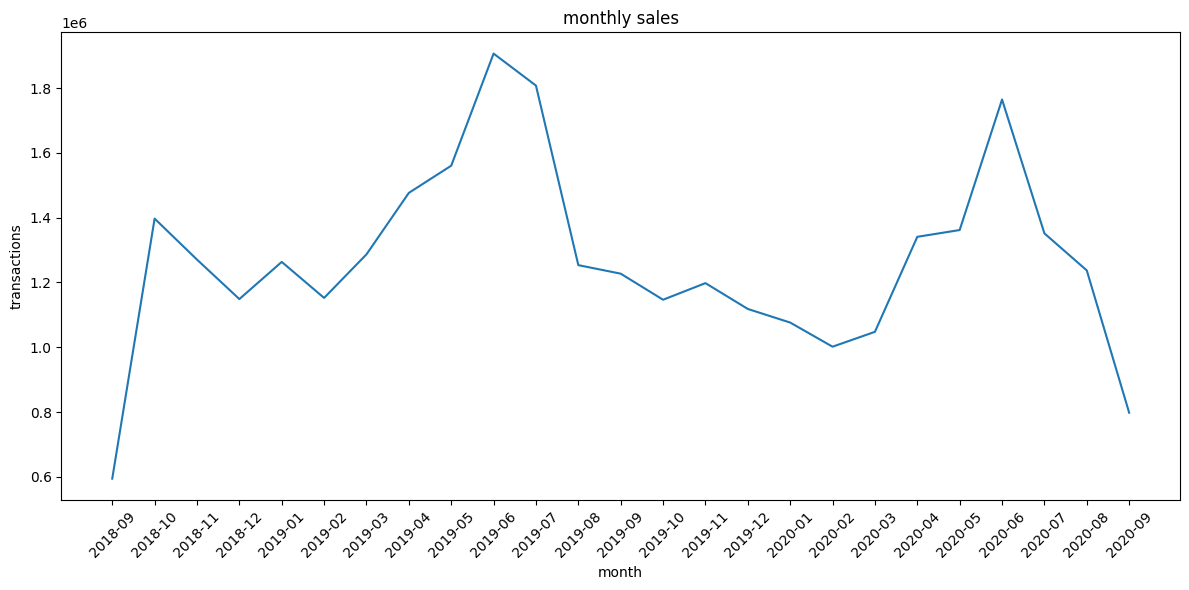

In [10]:
df_transactions['month_year'] = df_transactions['t_dat'].dt.to_period('M')
monthly_sales = df_transactions.groupby('month_year').size().reset_index(name='sales_count')

plt.figure(figsize=(12, 6))
sns.lineplot(x=[str(p) for p in monthly_sales['month_year']], y=monthly_sales['sales_count'])
plt.title('monthly sales')
plt.xlabel('month')
plt.ylabel('transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

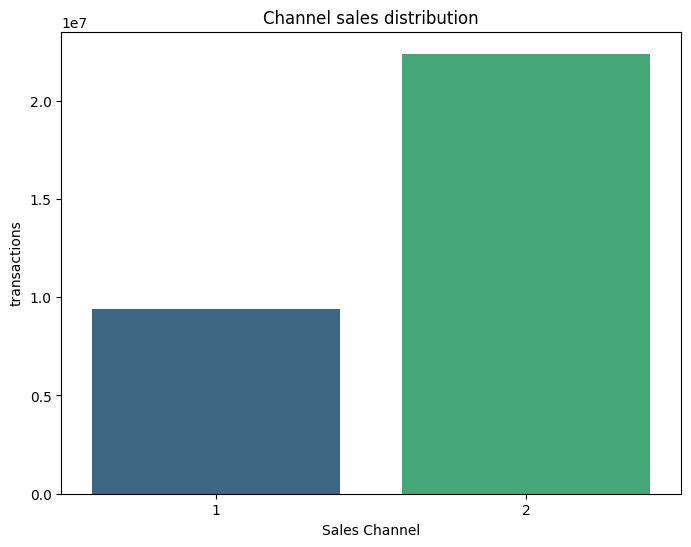

In [11]:
sales_channels = df_transactions['sales_channel_id'].value_counts().reset_index()
sales_channels.columns = ['channel', 'count']

plt.figure(figsize=(8, 6))
sns.barplot(x='channel', y='count', data=sales_channels, palette='viridis')
plt.title('Channel sales distribution')
plt.xlabel('Sales Channel')
plt.ylabel('transactions')
plt.show()

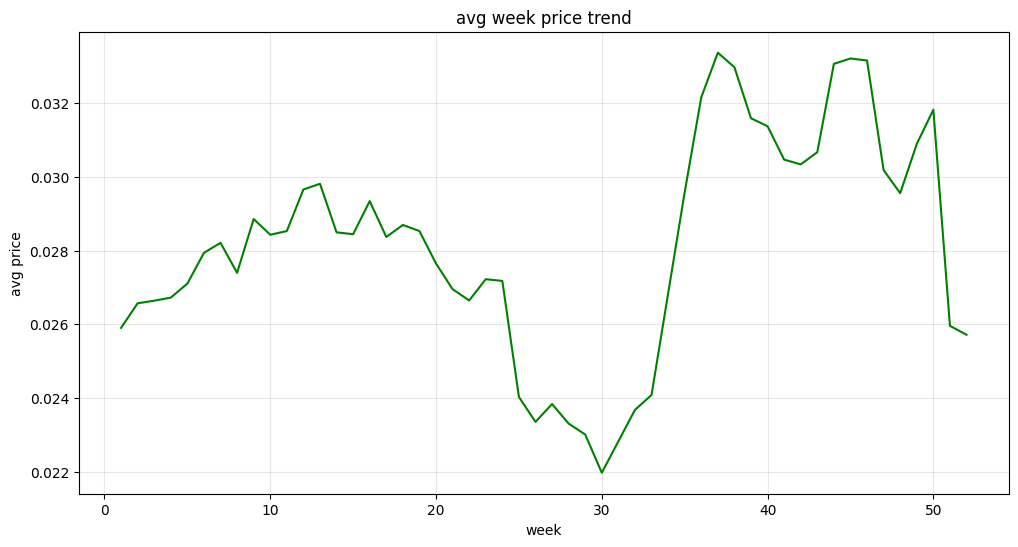

In [12]:
df_transactions['week'] = df_transactions['t_dat'].dt.isocalendar().week
weekly_avg_price = df_transactions.groupby(['week'])['price'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='week', y='price', data=weekly_avg_price, color='green')
plt.title('avg week price trend')
plt.xlabel('week')
plt.ylabel('avg price')
plt.grid(True, alpha=0.3)
plt.show()

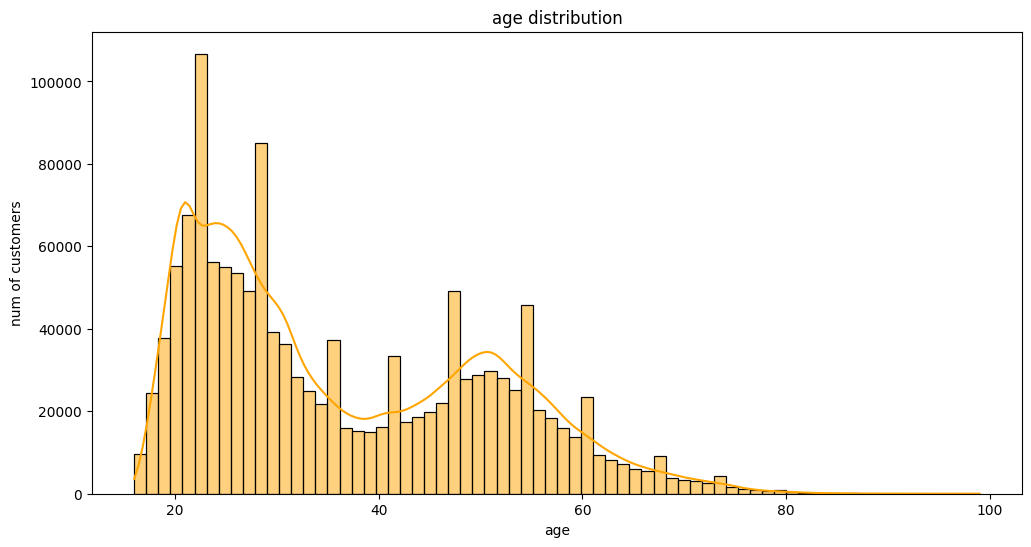

In [13]:
plt.figure(figsize=(12, 6))
sns.histplot(df_customers['age'].dropna(), bins=70, kde=True, color='orange')
plt.title('age distribution')
plt.xlabel('age')
plt.ylabel('num of customers')
plt.show()

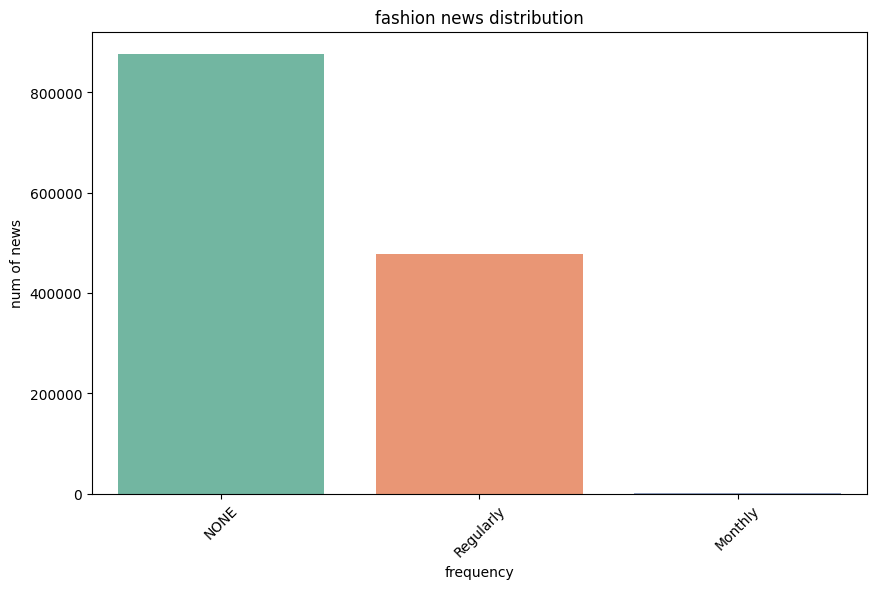

In [14]:
fashion_news = df_customers['fashion_news_frequency'].value_counts().reset_index()
fashion_news.columns = ['frequency', 'count']

plt.figure(figsize=(10, 6))
sns.barplot(x='frequency', y='count', data=fashion_news, palette='Set2')
plt.title('fashion news distribution')
plt.xlabel('frequency')
plt.ylabel('num of news')
plt.xticks(rotation=45)
plt.show()

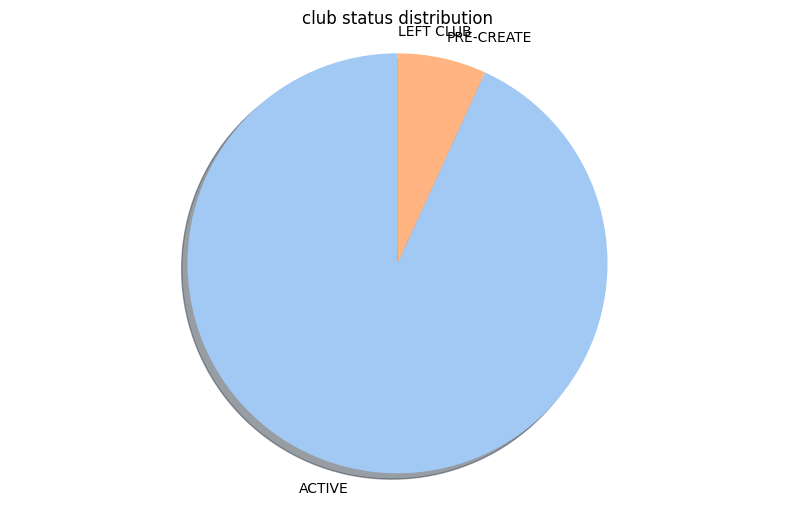

In [15]:
club_status = df_customers['club_member_status'].value_counts().reset_index()
club_status.columns = ['status', 'count']

plt.figure(figsize=(10, 6))
plt.pie(club_status['count'], labels=club_status['status'], shadow=True, startangle=90, colors=sns.color_palette('pastel'))
plt.title('club status distribution')
plt.axis('equal')
plt.show()

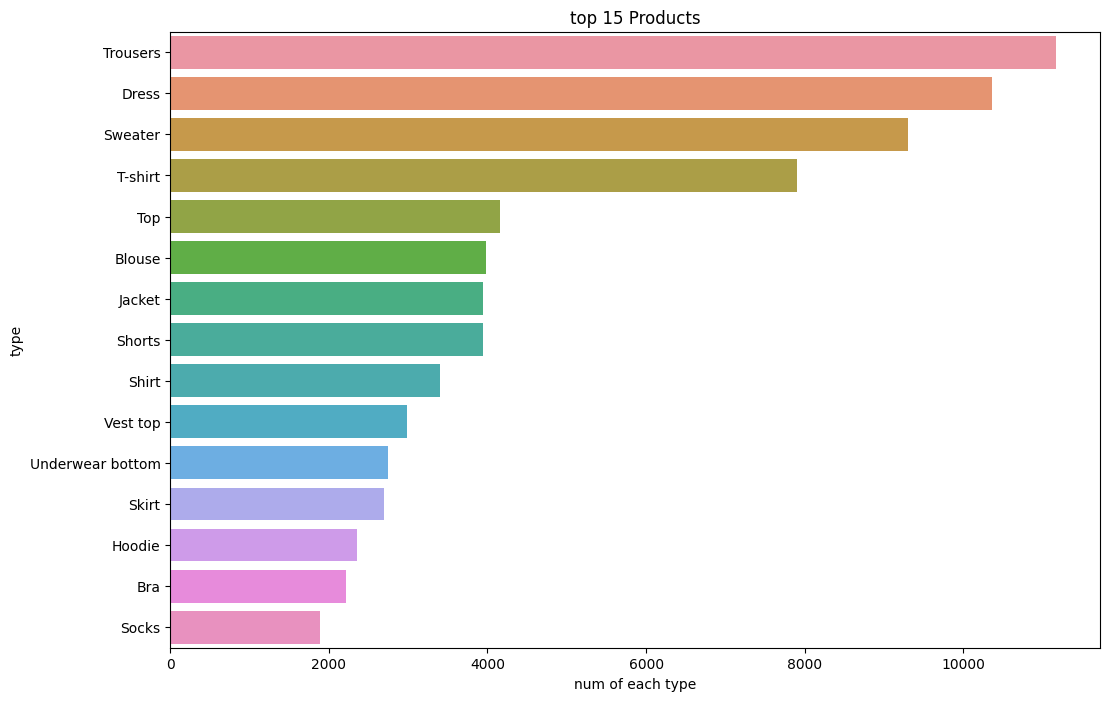

In [16]:
product_types = df_articles['product_type_name'].value_counts().head(15).reset_index()
product_types.columns = ['product_type', 'count']

plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='product_type', data=product_types)
plt.title('top 15 Products')
plt.xlabel('num of each type')
plt.ylabel('type')
plt.show()

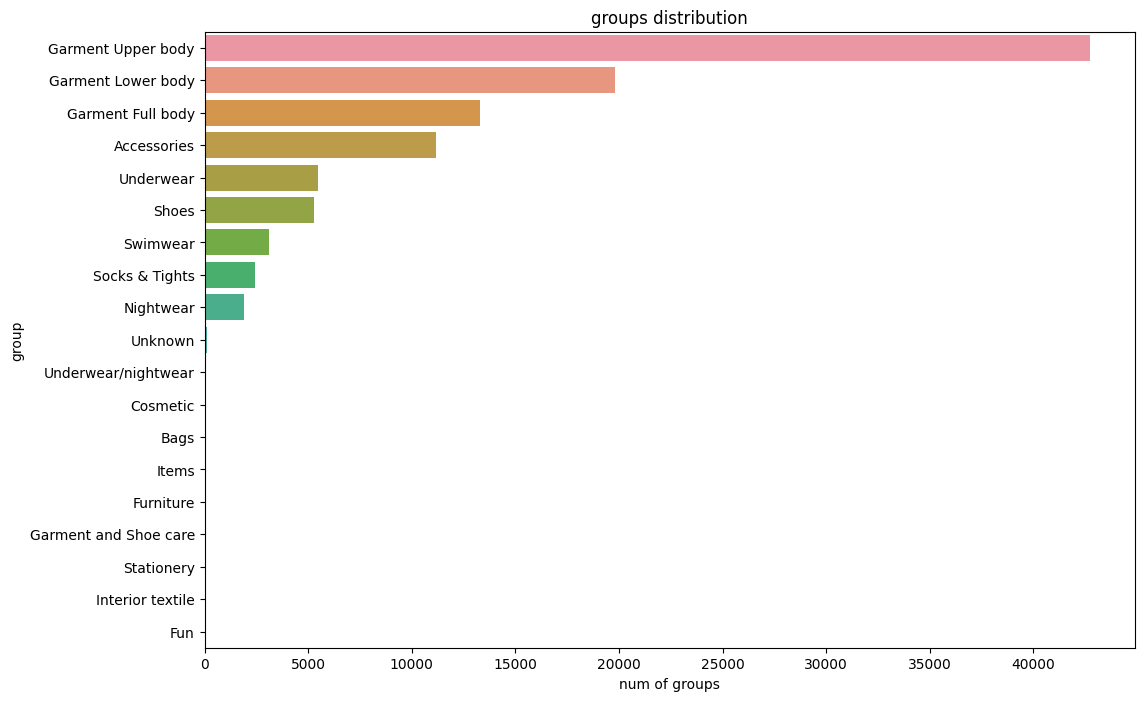

In [17]:
product_groups = df_articles['product_group_name'].value_counts().reset_index()
product_groups.columns = ['product_group', 'count']

plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='product_group', data=product_groups)
plt.title('groups distribution')
plt.xlabel('num of groups')
plt.ylabel('group')
plt.show()

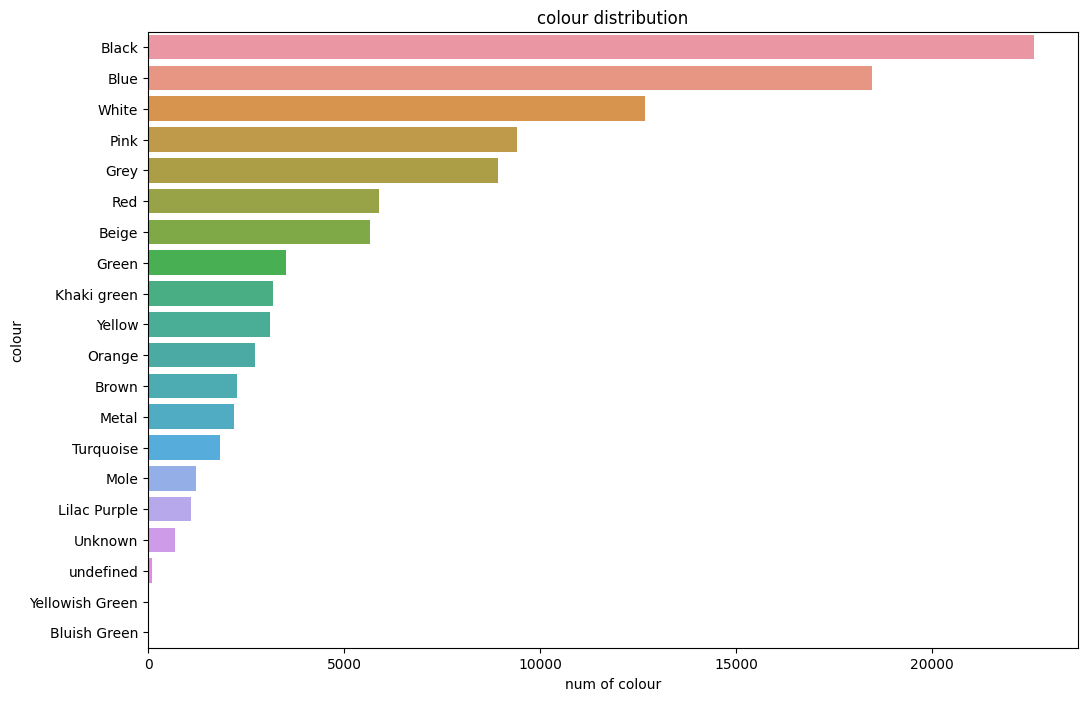

In [18]:
colors = df_articles['perceived_colour_master_name'].value_counts().reset_index()
colors.columns = ['color', 'count']

plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='color', data=colors)
plt.title('colour distribution')
plt.xlabel('num of colour')
plt.ylabel('colour')
plt.show()

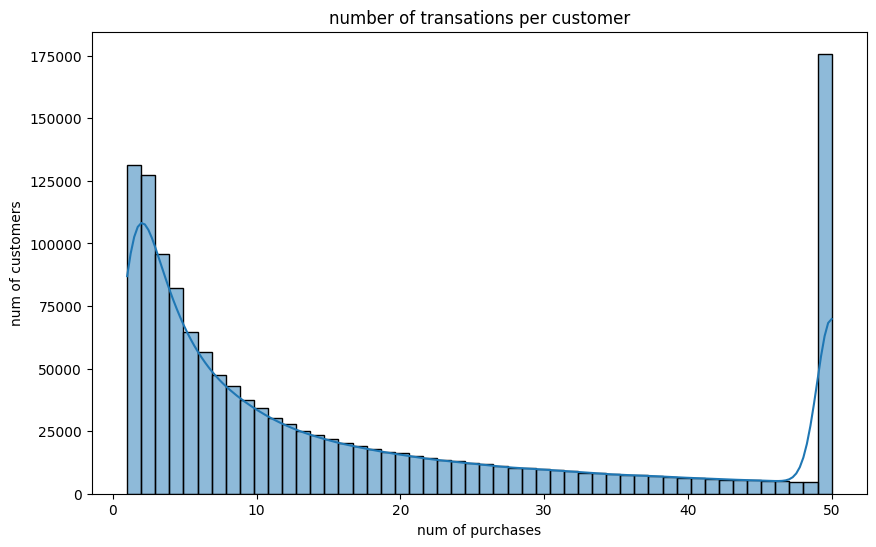

In [19]:
# distribution is highly scewed. Some customres make way too many transactions.
customer_purchase_counts = df_transactions.groupby('customer_id').size().reset_index(name='purchase_count')

plt.figure(figsize=(10, 6))
sns.histplot(customer_purchase_counts['purchase_count'].clip(upper=50), bins=50, kde=True)
plt.title('number of transations per customer')
plt.xlabel('num of purchases')
plt.ylabel('num of customers')
plt.show()

In [20]:
# top 10 customers
customer_purchase_counts.sort_values('purchase_count', ascending=False).head(10)

,customer_id,purchase_count
1011710,be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee9...,1895
962395,b4db5e5259234574edfff958e170fe3a5e13b6f146752c...,1441
391840,49beaacac0c7801c2ce2d189efe525fe80b5d37e46ed05...,1364
885174,a65f77281a528bf5c1e9f270141d601d116e1df33bf9df...,1361
1090960,cd04ec2726dd58a8c753e0d6423e57716fd9ebcf2f14ed...,1237
456062,55d15396193dfd45836af3a6269a079efea339e875eff4...,1208
1028179,c140410d72a41ee5e2e3ba3d7f5a860f337f1b5e41c27c...,1170
755132,8df45859ccd71ef1e48e2ee9d1c65d5728c31c46ae957d...,1169
20162,03d0011487606c37c1b1ed147fc72f285a50c05f00b971...,1157
578832,6cc121e5cc202d2bf344ffe795002bdbf87178054bcda2...,1143


In [21]:
# analogously top 10 items
popular_items = df_transactions.groupby('article_id').size().reset_index(name='purchase_count')
popular_items = popular_items.sort_values('purchase_count', ascending=False).head(10)

popular_items

,article_id,purchase_count
53832,0706016001,50287
53833,0706016002,35043
1711,0372860001,31718
24808,0610776002,30199
70124,0759871002,26329
3706,0464297007,25025
1712,0372860002,24458
24807,0610776001,22451
2233,0399223001,22236
53834,0706016003,21241


In [22]:
# tyoe of products and name for top items. Mostly a little purchases, like trousers and socks
top_items_details = pd.merge(popular_items, df_articles[['article_id', 'prod_name', 'product_type_name']], on='article_id', how='left')

top_items_details

,article_id,purchase_count,prod_name,product_type_name
0,0706016001,50287,Jade HW Skinny Denim TRS,Trousers
1,0706016002,35043,Jade HW Skinny Denim TRS,Trousers
2,0372860001,31718,7p Basic Shaftless,Socks
3,0610776002,30199,Tilly (1),T-shirt
4,0759871002,26329,Tilda tank,Vest top
5,0464297007,25025,Greta Thong Mynta Low 3p,Underwear bottom
6,0372860002,24458,7p Basic Shaftless,Socks
7,0610776001,22451,Tilly (1),T-shirt
8,0399223001,22236,Curvy Jeggings HW Ankle,Trousers
9,0706016003,21241,Jade HW Skinny Denim TRS,Trousers


In [23]:
# What's the most and least popular in terms of price? 
# Wow women tops and bra among the most popular choices. Some of the most unpopular are 
item_price_popularity = df_transactions.groupby('article_id').agg({'price': 'mean', 'article_id': 'count'})
item_price_popularity.columns = ['avg_price', 'popularity']
item_price_popularity = item_price_popularity.reset_index().merge(df_articles[['article_id', 'prod_name', 'product_type_name']], on='article_id', how='left')
item_price_popularity



,article_id,avg_price,popularity,prod_name,product_type_name
0,0108775015,0.0081,10841,Strap top,Vest top
1,0108775044,0.0081,7250,Strap top,Vest top
2,0108775051,0.0050,215,Strap top (1),Vest top
3,0110065001,0.0202,1044,OP T-shirt (Idro),Bra
4,0110065002,0.0182,539,OP T-shirt (Idro),Bra
...,...,...,...,...,...
104542,0952267001,0.0150,41,Heavy plain overknee tights 1p,Underwear Tights
104543,0952938001,0.0480,9,Elton top,Top
104544,0953450001,0.0168,17,5pk regular Placement1,Socks
104545,0953763001,0.0219,35,SPORT Malaga tank,Vest top


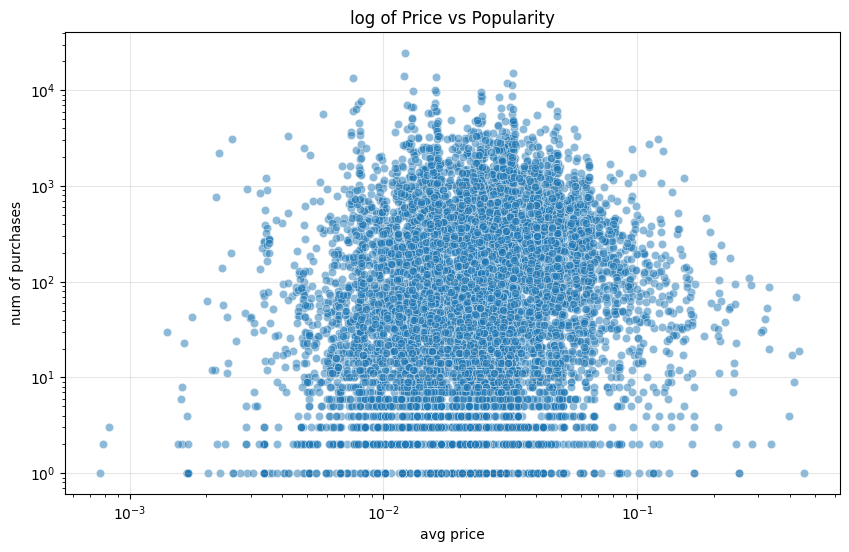

In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_price', y='popularity', data=item_price_popularity.sample(10000), alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.title('log of Price vs Popularity')
plt.xlabel('avg price')
plt.ylabel('num of purchases')
plt.grid(True, alpha=0.3)
plt.show()

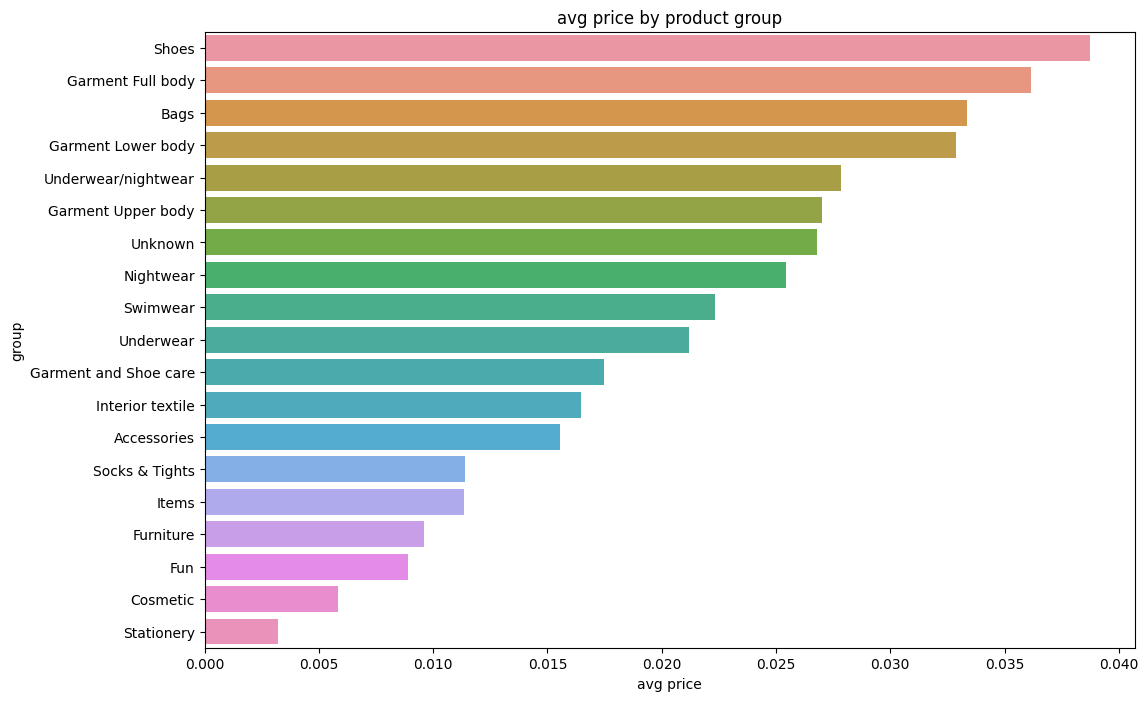

In [25]:
# price analysis by product category
merged_data = pd.merge(df_transactions, df_articles[['article_id', 'product_group_name', 'product_type_name']], 
                      on='article_id', how='left')

avg_price_by_group = merged_data.groupby('product_group_name')['price'].mean().reset_index()
avg_price_by_group = avg_price_by_group.sort_values('price', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='price', y='product_group_name', data=avg_price_by_group)
plt.title('avg price by product group')
plt.xlabel('avg price')
plt.ylabel('group')
plt.show()

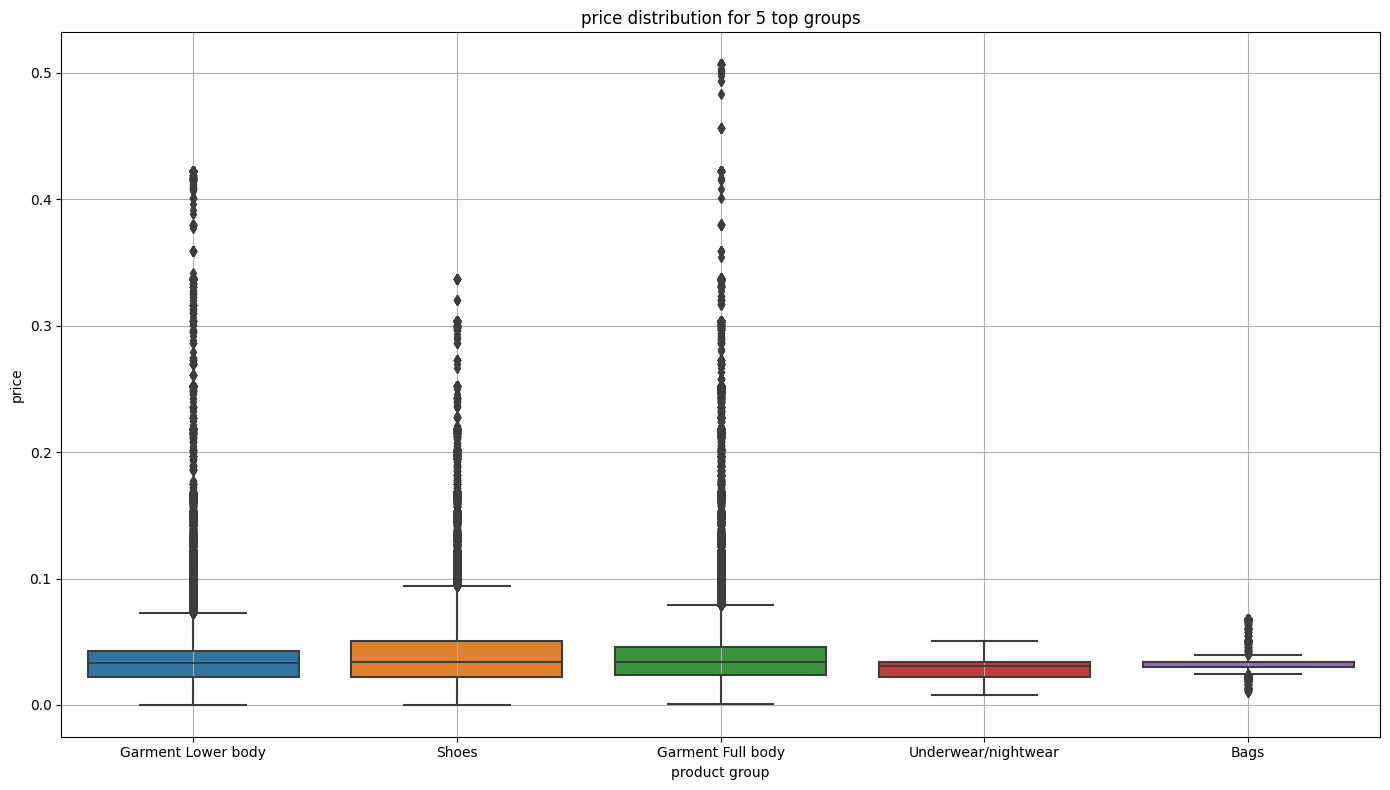

In [26]:
# price distributions within 5 top groups
top_5_groups = avg_price_by_group.head(5)['product_group_name'].tolist()
top_groups_data = merged_data[merged_data['product_group_name'].isin(top_5_groups)]

plt.figure(figsize=(14, 8))
sns.boxplot(x='product_group_name', y='price', data=top_groups_data)
plt.title('price distribution for 5 top groups')
plt.xlabel('product group')
plt.ylabel('price')
plt.grid()
plt.tight_layout()
plt.show()

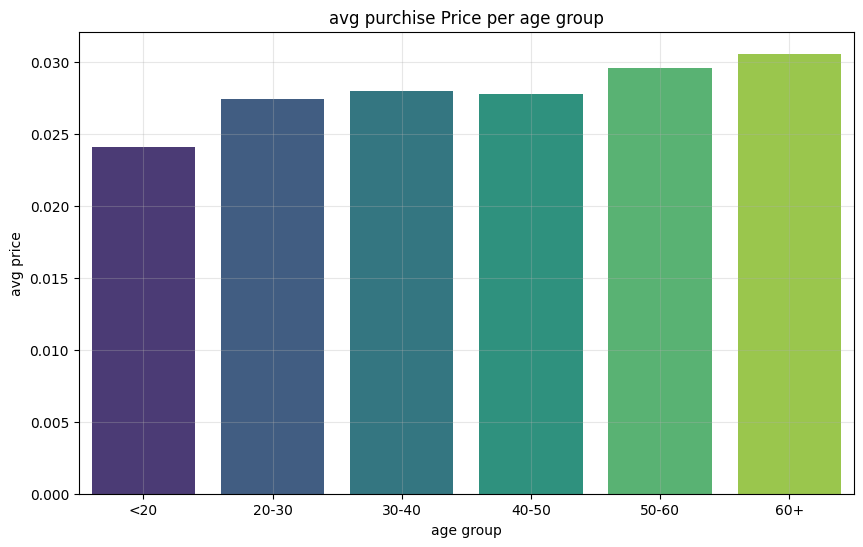

In [27]:
# purchase patterns search

merged_cust_data = pd.merge(df_transactions, df_customers[['customer_id', 'age']], on='customer_id', how='left')
merged_cust_data = merged_cust_data.dropna(subset=['age'])

bins_list = [0, 20, 30, 40, 50, 60, 100]
names_list = ['<20', '20-30', '30-40', '40-50', '50-60', '60+']

merged_cust_data['age_bin'] = pd.cut(merged_cust_data['age'], bins=bins_list, labels=names_list)

age_group_spending = merged_cust_data.groupby('age_bin')['price'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='age_bin', y='price', data=age_group_spending, palette='viridis')
plt.title('avg purchise Price per age group')
plt.xlabel('age group')
plt.ylabel('avg price')
plt.grid(True, alpha=0.3)
plt.show()

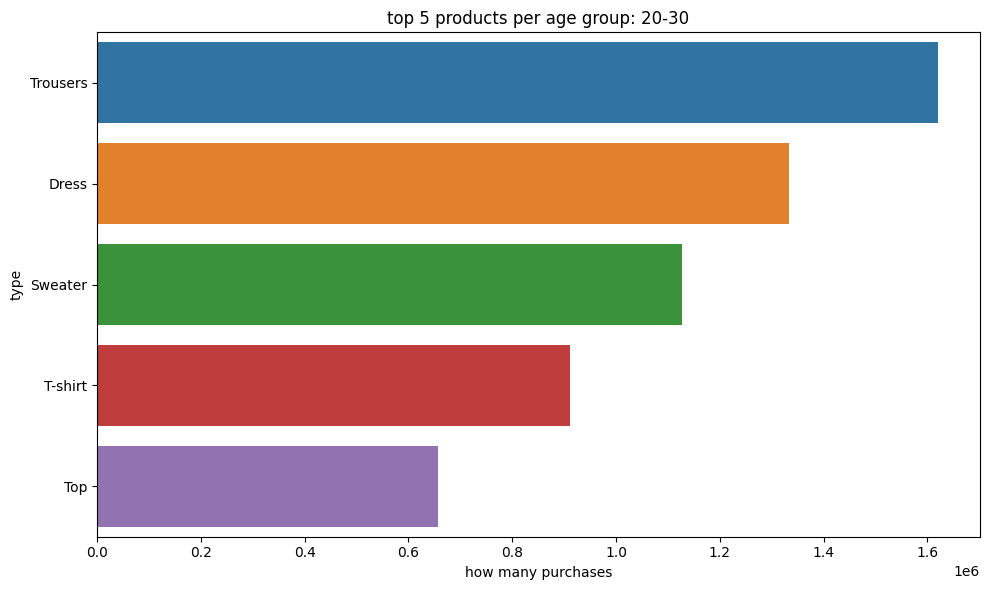

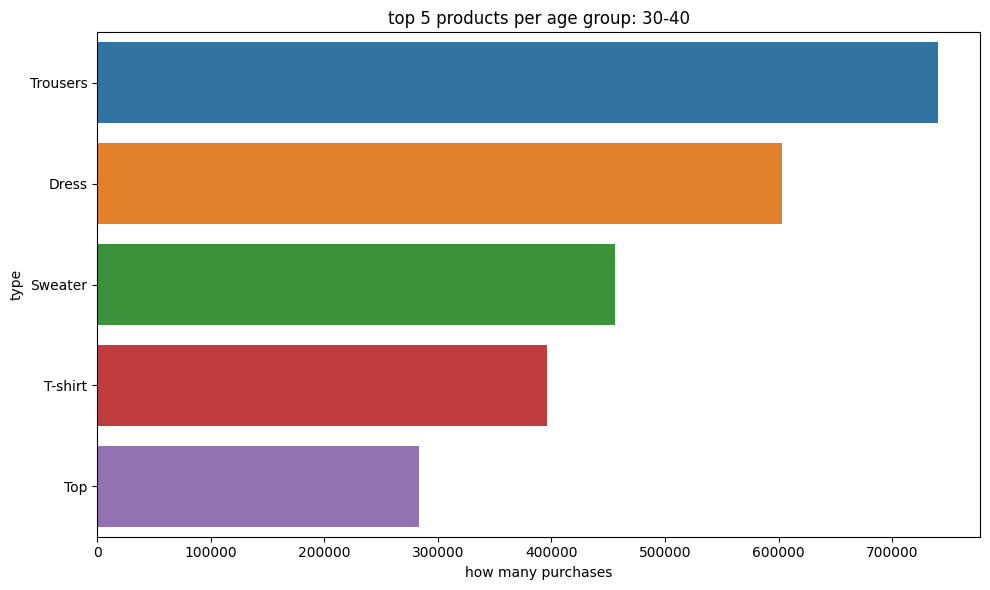

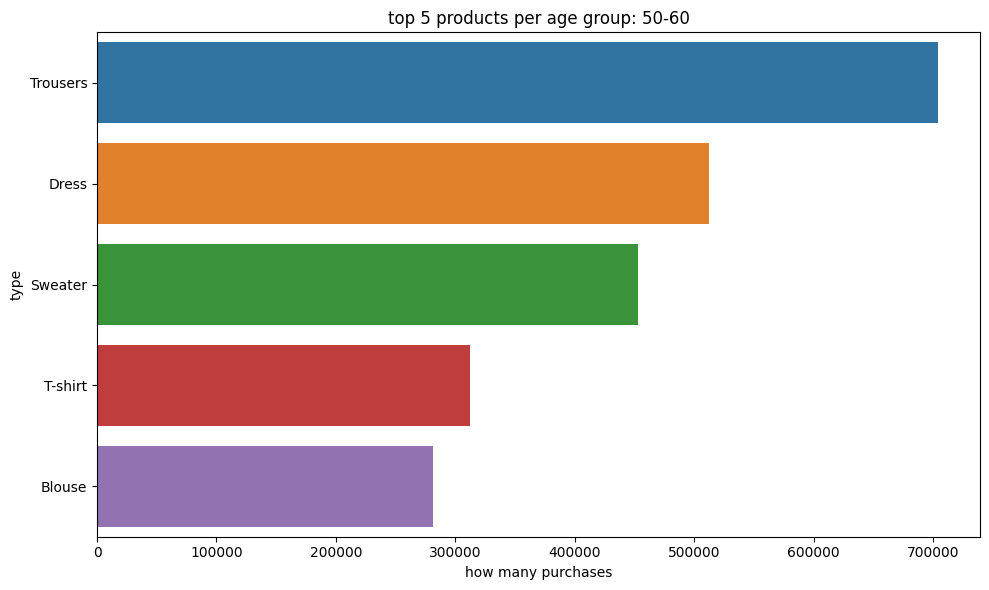

In [28]:
# Most selling product per age group

key_age_groups = ['20-30', '30-40', '50-60']
age_product_data = pd.merge(merged_cust_data, df_articles[['article_id', 'product_type_name']], on='article_id', how='left')

for age_group in key_age_groups:
    group_data = age_product_data[age_product_data['age_bin'] == age_group]
    top_products = group_data['product_type_name'].value_counts().head(5)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_products.values, y=top_products.index)
    plt.title(f'top 5 products per age group: {age_group}')
    plt.xlabel('how many purchases')
    plt.ylabel('type')
    plt.tight_layout()
    plt.show()

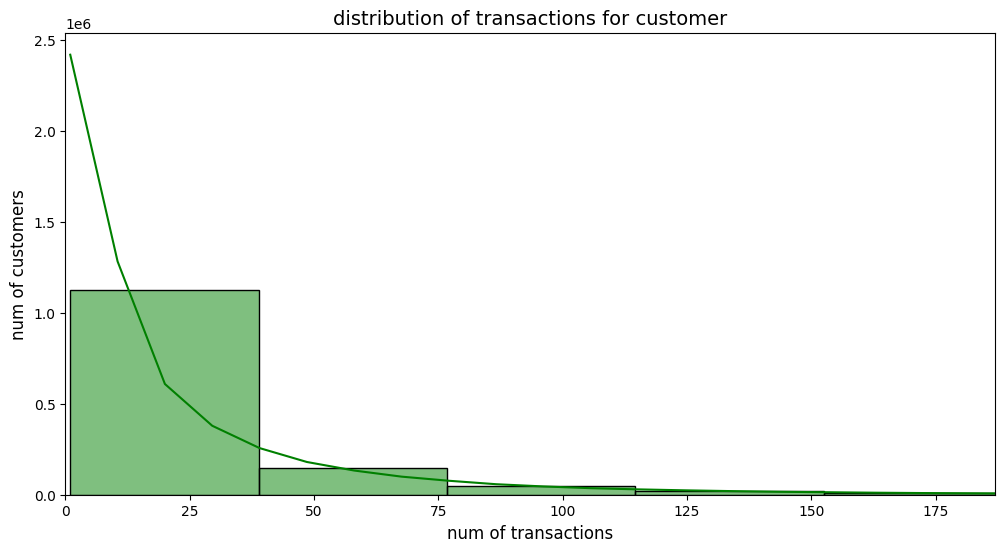

In [29]:
# Transactions per customer
transactions_per_customer = df_transactions.groupby('customer_id').size().reset_index(name='transaction_count')

plt.figure(figsize=(12, 6))
sns.histplot(data=transactions_per_customer, x='transaction_count', bins=50, kde=True, color='green')
plt.title('distribution of transactions for customer', fontsize=14)
plt.xlabel('num of transactions', fontsize=12)
plt.ylabel('num of customers', fontsize=12)
plt.xlim(0, transactions_per_customer['transaction_count'].quantile(0.99))
plt.show()

# Data preprocessing

In [14]:
# convert customer_id to numeric format
df_transactions['customer_id_int'] = df_transactions['customer_id'].apply(lambda x: int(x[-16:], 16))

# let's filter unnecesary columns
df_transactions = df_transactions[['t_dat', 'customer_id', 'customer_id_int', 'article_id']]

df_sample_submission['customer_id_int'] = df_sample_submission['customer_id'].apply(lambda x: int(x[-16:], 16)) # same for submission dataframe

## Split data into train and test based on time

In [15]:
# get last date from all transactions
last_date = df_transactions['t_dat'].max()
print(f'Last date in all transactions: {last_date}')

# define test start date as 7 days before the last date
test_start_date = last_date - timedelta(days=7)
print(f'Test start date: {test_start_date}')

# test transactions are transactions from the last week
df_transactions_test = df_transactions[df_transactions['t_dat'] >= test_start_date].copy()
print(f'Test transactions dates from {df_transactions_test["t_dat"].min()} to {df_transactions_test["t_dat"].max()}, shape: {df_transactions_test.shape}')

# train transactions are all transactions before the test week
df_transactions_train = df_transactions[df_transactions['t_dat'] < test_start_date].copy()
print(f'Train transactions dates from {df_transactions_train["t_dat"].min()} to {df_transactions_train["t_dat"].max()}, shape: {df_transactions_train.shape}')

# get the last date of the training period
last_date_train = df_transactions_train['t_dat'].max()
print(f'Last date in train transactions: {last_date_train}')

Last date in all transactions: 2020-09-22 00:00:00
Test start date: 2020-09-15 00:00:00
Test transactions dates from 2020-09-15 00:00:00 to 2020-09-22 00:00:00, shape: (266364, 4)
Train transactions dates from 2018-09-20 00:00:00 to 2020-09-14 00:00:00, shape: (31521960, 4)
Last date in train transactions: 2020-09-14 00:00:00


# Evalation metrics function

In [24]:
def evaluate_recommendations(actual_df, pred_dfs, k=12):
    """
    Main metrics evaluation function. Can receive list of predictions

    Input: actual_df - dataframe with actual purchases
    pred_dfs : list of dataframes with predicted recommendations
    k : num of K at MAP
    Returns: metrics dataframe
    """

    # Actual purchases to dict
    actual_purchases = defaultdict(set)
    for _, row in actual_df.iterrows():
        actual_purchases[row['customer_id_int']].add(row['article_id']) # Используем 'customer_id_int'

    results = {
        f'map@{k}': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'rmse': [],
    }

    total_items = len(actual_df['article_id'].unique())

    for pred_df in pred_dfs:
        # track metrics
        ap_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []
        rmse_scores = []
        predicted_items_set = set()
        recommendation_count = 0
        pop_scores = []

        # loop for all predictions
        for _, row in pred_df.iterrows():
            customer_id = row['customer_id_int']

            # no purchases
            if customer_id not in actual_purchases:
                continue

            # Get items
            if isinstance(row['prediction'], str):
                pred_items = row['prediction'].strip().split()[:k]
            else:
                pred_items = []

            for item in pred_items:
                predicted_items_set.add(item)
            recommendation_count += len(pred_items)

            # no predictions
            if not pred_items:
                continue

            # get items for customer
            actual_items = actual_purchases[customer_id]

            hits = 0
            sum_precisions = 0

            for i, item in enumerate(pred_items):
                if item in actual_items:
                    hits += 1
                    precision_at_i = hits / (i + 1)
                    sum_precisions += precision_at_i

            if hits > 0:
                ap = sum_precisions / min(len(actual_items), k)
            else:
                ap = 0
            ap_scores.append(ap)

            # Calculate metrics
            true_positives = len(set(pred_items) & actual_items)
            precision = true_positives / len(pred_items) if pred_items else 0
            recall = true_positives / len(actual_items) if actual_items else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)

            # RMSE for binary variant, when 1 if there is a hit, 0 otherwise
            actual_vector = np.zeros(total_items)
            pred_vector = np.zeros(total_items)

            for item in actual_items:
                try:
                    item_idx = int(item) % total_items
                except ValueError:
                    item_idx = hash(item) % total_items
                actual_vector[item_idx] = 1

            for item in pred_items:
                try:
                    item_idx = int(item) % total_items
                except ValueError:
                    item_idx = hash(item) % total_items
                pred_vector[item_idx] = 1

            rmse = np.sqrt(mean_squared_error(actual_vector, pred_vector))
            rmse_scores.append(rmse)

        results[f'map@{k}'].append(np.mean(ap_scores) if ap_scores else 0)
        results['precision'].append(np.mean(precision_scores) if precision_scores else 0)
        results['recall'].append(np.mean(recall_scores) if recall_scores else 0)
        results['f1_score'].append(np.mean(f1_scores) if f1_scores else 0)
        results['rmse'].append(np.mean(rmse_scores) if rmse_scores else 0)

    metrics_df = pd.DataFrame(results)
    return metrics_df

In [25]:
# function to ensure, we have exactly 12 predictions for each customer

def ensure_12_items(predicted_items, popular_items):
    if not isinstance(predicted_items, list):
        predicted_items = []  

    if len(predicted_items) >= 12:
        return predicted_items[:12]
    else:
        remaining = 12 - len(predicted_items)
        popular_to_add = [item for item in popular_items if item not in predicted_items] 
        return predicted_items + popular_to_add[:remaining]

# Baselines 
## Last month purchase
I suggest buiding a couple of baselines before implementing final recommendation model. First baselines will be about recommending most recently purchased item for last month

In [36]:
cutoff_date = last_date_train - timedelta(days=30)
print(f'Cutoff date for recent transactions: {cutoff_date}')

# get transactions for last 30 days
df_recent_transactions_train = df_transactions_train[df_transactions_train['t_dat'] >= cutoff_date].copy()
print(f"Transactions for recent period from {cutoff_date} to {last_date_train}: {df_recent_transactions_train.shape}")

# how many days ago each purchase was made
df_recent_transactions_train['recency'] = (last_date_train - df_recent_transactions_train['t_dat']).dt.days

df_recent_transactions_train.head()

Cutoff date for recent transactions: 2020-08-15 00:00:00
Transactions for recent period from 2020-08-15 00:00:00 to 2020-09-14 00:00:00: (1153155, 4)


,t_dat,customer_id,customer_id_int,article_id,recency
30368805,2020-08-15,000a9291e5aa007a10faf2177671a8501dade80e667921...,7346844426266836871,0878097002,30
30368806,2020-08-15,000c0995dc7f3fbec41cf1cb2c535f6e2ae99c0fe351e4...,922397346549787974,0153115021,30
30368807,2020-08-15,0011e0bd4c39195ff342c0ca0ac0601ce2b943a8265506...,2993305664918359664,0865929003,30
30368808,2020-08-15,001ea4e9c54f7e9c88811260d954edc059d596147e1cf8...,14353855670801342424,0882899012,30
30368809,2020-08-15,001ea4e9c54f7e9c88811260d954edc059d596147e1cf8...,14353855670801342424,0860949002,30


In [35]:
# we need to know the latest min recency for each cusomter_id and article id pairs
customer_article_metrics_baseline_1 = (df_recent_transactions_train
                                    .groupby(['customer_id_int', 'article_id'])
                                    .agg(purchase_count=('t_dat', 'count'),
                                         last_purchase=('t_dat', 'max'),
                                         min_recency=('recency', 'min'))
                                    .reset_index()
                                   )


customer_article_metrics_baseline_1.head()

,customer_id_int,article_id,purchase_count,last_purchase,min_recency
0,28847241659200,0760084003,1,2020-08-31,14
1,28847241659200,0925246001,1,2020-09-03,11
2,116809474287335,0806131001,1,2020-08-26,19
3,116809474287335,0826498001,1,2020-08-26,19
4,116809474287335,0873217004,1,2020-08-26,19


In [37]:
customer_article_metrics_baseline_1.head()

,customer_id_int,article_id,purchase_count,last_purchase,min_recency
0,28847241659200,0760084003,1,2020-08-31,14
1,28847241659200,0925246001,1,2020-09-03,11
2,116809474287335,0806131001,1,2020-08-26,19
3,116809474287335,0826498001,1,2020-08-26,19
4,116809474287335,0873217004,1,2020-08-26,19


In [38]:
# sorting the metrics. Purchase sorting is irrelevant. We want to know only customer id and it's most recent number of days
customer_article_metrics_baseline_1 = customer_article_metrics_baseline_1.sort_values(
    ['customer_id_int', 'purchase_count', 'min_recency'],
    ascending=[True, False, True]
)

# previous sorting was neeeded for this drop of duplicates. Only top recensy remain
customer_article_metrics_baseline_1 = customer_article_metrics_baseline_1.drop_duplicates(['customer_id_int', 'article_id'])


customer_article_metrics_baseline_1.head()


,customer_id_int,article_id,purchase_count,last_purchase,min_recency
1,28847241659200,0925246001,1,2020-09-03,11
0,28847241659200,0760084003,1,2020-08-31,14
5,116809474287335,0906305002,1,2020-09-12,2
2,116809474287335,0806131001,1,2020-08-26,19
3,116809474287335,0826498001,1,2020-08-26,19


In [39]:
# Convert customer_article_metrics to dictionary for faster search- hashtable is fast

customer_items_baseline_1 = {}
for _, row in customer_article_metrics_baseline_1.iterrows():
    customer_id = row['customer_id_int']
    article_id = row['article_id']

    if customer_id not in customer_items_baseline_1:
        customer_items_baseline_1[customer_id] = []

    if len(customer_items_baseline_1[customer_id]) < 12:  # need 12 items for customer
        customer_items_baseline_1[customer_id].append(article_id)

In [40]:
# solving issues with cold start and filling missing predictions
# popular items from last 2 weeks

last_2weeks_date = last_date_train - timedelta(days=14)
last_2weeks_transactions_train = df_transactions_train[df_transactions_train['t_dat'] >= last_2weeks_date] 
popular_items_baseline_1 = last_2weeks_transactions_train['article_id'].value_counts().head(12).index.tolist()

print(popular_items_baseline_1)

['0751471001', '0915526001', '0751471043', '0918292001', '0706016001', '0909370001', '0915529003', '0448509014', '0898694001', '0863595006', '0918522001', '0896152002']


In [42]:
# Create predictions dataframe
predictions_baseline_1 = []
for customer_id, items in customer_items_baseline_1.items():
    items_str = ' '.join(items)
    predictions_baseline_1.append((customer_id, items_str))

df_predictions_baseline_1 = pd.DataFrame(predictions_baseline_1, columns=['customer_id_int', 'prediction'])


In [43]:
predictions_list_baseline_1 = []
for customer_id, items in customer_items_baseline_1.items():
    items_str = ' '.join(map(str, items)) # items to strings
    predictions_list_baseline_1.append((customer_id, items_str))

df_predictions_baseline_1 = pd.DataFrame(predictions_list_baseline_1, columns=['customer_id_int', 'prediction'])

print(df_predictions_baseline_1.head())

   customer_id_int                                         prediction
0   28847241659200                              0925246001 0760084003
1  116809474287335  0906305002 0806131001 0826498001 0873217004 09...
2  200292573348128                                         0903861001
3  272412481300040                   0921906005 0922381001 0923460002
4  329094189075899                                         0821338004


In [ ]:
# # submission template
# submission_baseline_1 = df_sample_submission.merge(
#     df_predictions_baseline_1, on='customer_id_int', how='left'
# ).fillna('')

# # filling na
# submission_baseline_1['prediction'] = submission_baseline_1['prediction'].apply(
#     lambda x: x if x != '' else ' '.join(map(str, popular_items_baseline_1[:12])) 
# )

# submission_baseline_1['prediction'] = submission_baseline_1['prediction'].apply(lambda x: ensure_12_items(x, popular_items_baseline_1))

# submission_baseline_1_final = submission_baseline_1[['customer_id', 'prediction']]

# print(submission_baseline_1_final.head())

In [44]:
metrics_baseline_one = evaluate_recommendations(
    df_transactions_test, 
    [df_predictions_baseline_1],
    k=12
)

metrics_baseline_one

,map@12,precision,recall,f1_score,rmse
0,0.0414,0.0371,0.0675,0.0412,0.0190


**Thoughts** \
map@12	0.0414	- means items are appearing in real data pretty rarely. Metric is obviosly low, but that's the part of the way. Just to get started we need some baseline to compare it to something. Ranking is not high for this one.

Precision - 0.0371 - it means that only about 3 percent of items being predicted correctly. That's low.

F1 score is also very low. That's it for first baseline. \

Time to shine for the second baseline.

## Second baseline

This one will be about to match items being bought together. 

In [46]:
# like for first baseline
cutoff_date_baseline_2 = last_date_train - timedelta(days=30)
df_transactions_train_baseline_2 = df_transactions[df_transactions['t_dat'] < test_start_date].copy()
last_date_train_baseline_2 = df_transactions_train_baseline_2['t_dat'].max() 
df_recent_transactions_train_baseline_2 = df_transactions_train_baseline_2[df_transactions_train_baseline_2['t_dat'] >= cutoff_date_baseline_2].copy() 
df_recent_transactions_train_baseline_2['recency'] = (last_date_train_baseline_2 - df_recent_transactions_train_baseline_2['t_dat']).dt.days


In [47]:
customer_article_metrics_baseline_2 = (df_recent_transactions_train_baseline_2 # Specific name for baseline 2
                                    .groupby(['customer_id_int', 'article_id'])
                                    .agg(purchase_count=('t_dat', 'count'),
                                         last_purchase=('t_dat', 'max'),
                                         min_recency=('recency', 'min'))
                                    .reset_index()
                                   )

customer_article_metrics_baseline_2.head()

,customer_id_int,article_id,purchase_count,last_purchase,min_recency
0,28847241659200,0760084003,1,2020-08-31,14
1,28847241659200,0925246001,1,2020-09-03,11
2,116809474287335,0806131001,1,2020-08-26,19
3,116809474287335,0826498001,1,2020-08-26,19
4,116809474287335,0873217004,1,2020-08-26,19


In [48]:
# remove duplicates - like for first baseline

customer_article_metrics_baseline_2 = customer_article_metrics_baseline_2.sort_values(['customer_id_int', 'purchase_count', 'min_recency'],
    ascending=[True, False, True])

customer_article_metrics_baseline_2 = customer_article_metrics_baseline_2.drop_duplicates(['customer_id_int', 'article_id']) 

customer_article_metrics_baseline_2.head()


,customer_id_int,article_id,purchase_count,last_purchase,min_recency
1,28847241659200,0925246001,1,2020-09-03,11
0,28847241659200,0760084003,1,2020-08-31,14
5,116809474287335,0906305002,1,2020-09-12,2
2,116809474287335,0806131001,1,2020-08-26,19
3,116809474287335,0826498001,1,2020-08-26,19


In [49]:
# convert for fast search

customer_items_baseline_2_strategy_1 = {} 
for _, row in customer_article_metrics_baseline_2.iterrows(): 
    customer_id = row['customer_id_int']
    article_id = row['article_id']

    if customer_id not in customer_items_baseline_2_strategy_1:
        customer_items_baseline_2_strategy_1[customer_id] = [] 

    if len(customer_items_baseline_2_strategy_1[customer_id]) < 12: 
        customer_items_baseline_2_strategy_1[customer_id].append(article_id) 

In [50]:
temp_df_baseline_2 = df_transactions_train_baseline_2.sort_values(['customer_id_int', 't_dat'])

pairs_dict_baseline_2 = {} 
window_days = 7

sample_size = min(10000, len(temp_df_baseline_2['customer_id_int'].unique())) 
customer_sample = np.random.choice(temp_df_baseline_2['customer_id_int'].unique(), size=sample_size, replace=False) 

for customer_id in customer_sample:
    customer_purchases = temp_df_baseline_2[temp_df_baseline_2['customer_id_int'] == customer_id] 

    for i, row1 in customer_purchases.iterrows():
        item1 = row1['article_id']
        purchase_date = row1['t_dat']

        window_purchases = customer_purchases[
            (customer_purchases['t_dat'] >= purchase_date) &
            (customer_purchases['t_dat'] <= purchase_date + timedelta(days=window_days)) &
            (customer_purchases['article_id'] != item1)
        ]

        for item2 in window_purchases['article_id'].unique():
            pair = (item1, item2)
            if pair not in pairs_dict_baseline_2: 
                pairs_dict_baseline_2[pair] = 0 
            pairs_dict_baseline_2[pair] += 1 

# Convert dict to dataframe
pairs_df_baseline_2 = pd.DataFrame([(k[0], k[1], v) for k, v in pairs_dict_baseline_2.items()], columns=['item1', 'item2', 'count'])
pairs_df_baseline_2 = pairs_df_baseline_2.sort_values('count', ascending=False)  

item_to_pair_baseline_2 = {} 
for _, row in pairs_df_baseline_2.iterrows(): 
    item1 = row['item1']
    item2 = row['item2']
    if item1 not in item_to_pair_baseline_2: 
        item_to_pair_baseline_2[item1] = item2 


In [51]:
customer_items_baseline_2 = customer_items_baseline_2_strategy_1.copy() 

for customer_id, items in customer_items_baseline_2.items():
    paired_items = []
    for item in items:
        if item in item_to_pair_baseline_2: 
            paired_items.append(item_to_pair_baseline_2[item]) 

    for item in paired_items:
        if item not in customer_items_baseline_2[customer_id] and len(customer_items_baseline_2[customer_id]) < 12:
            customer_items_baseline_2[customer_id].append(item)

In [52]:
# predictions 
predictions_list_baseline_2 = []
for customer_id, items in customer_items_baseline_2.items():
    items_str = ' '.join(map(str, items)) 
    predictions_list_baseline_2.append((customer_id, items_str))

df_predictions_baseline_2 = pd.DataFrame(predictions_list_baseline_2, columns=['customer_id_int', 'prediction'])

df_predictions_baseline_2.head()

,customer_id_int,prediction
0,28847241659200,0925246001 0760084003 0866244003 0760084008
1,116809474287335,0906305002 0806131001 0826498001 0873217004 09...
2,200292573348128,0903861001 0873564003
3,272412481300040,0921906005 0922381001 0923460002 0921906001 08...
4,329094189075899,0821338004 0809628003


In [ ]:
# submission_baseline_2 = df_sample_submission.merge(df_predictions_baseline_2, on='customer_id_int', how='left').fillna('')

# submission_baseline_2['prediction'] = submission_baseline_2['prediction'].apply(lambda x: x if x != '' else ' '.join(map(str, popular_items_baseline_2[:12])) )

# submission_baseline_2['prediction'] = submission_baseline_2['prediction'].apply(lambda x: ensure_12_items(x, popular_items_baseline_2)) 

# submission_baseline_2_final = submission_baseline_2[['customer_id', 'prediction']]

# print(submission_baseline_2_final.head())

In [53]:
metrics_baseline_two = evaluate_recommendations(
    df_transactions_test,
    [df_predictions_baseline_2],
    k=12
)

metrics_baseline_two

,map@12,precision,recall,f1_score,rmse
0,0.0425,0.0255,0.0716,0.0331,0.0220


**Thoughts**

Very much mixed picture on metrics. 

map@12 increased slightly, but still low. We miss predictions too much. Relevant items in top 12 ranking a little better with baseline 2. Improvement very slight. 

In the same time there is precision drop compare to first baseline, so actually odd of seeing right recommendation dropped a lot. 

f1 score also droppped due to high drop in precision. 

Conclusion - both baselines are weak and not going to any production :)

# ALS model

In [68]:
# This function will create sparse matrix - need this for collaborative filtering
def create_user_item_matrix(df, all_users, all_items):
    # Need integer indices for sparse matrix
    row = df['user_idx'].astype(int).values
    col = df['item_idx'].astype(int).values
    data = np.ones(df.shape[0]) 
    
    coo = coo_matrix((data, (row, col)), shape=(len(all_users), len(all_items)))
    return coo

In [69]:
# function returning recommendations. There is several datasets, like submission and test datasets
def generate_recommendations(model, user_indices, csr_train, item_ids, num_recommendations=12):
    recommendations = {}
    
    # Loop through users to get recommendations
    for user_idx in tqdm(user_indices):
        user_idx = int(user_idx)  # Convert to int just to be safe
        
        user_items = csr_train[user_idx] if user_idx < csr_train.shape[0] else None
        
        try:
            recommended_items, _ = model.recommend(
                user_idx, 
                user_items,
                N=num_recommendations,
                filter_already_liked_items=True  # do not recommend items already existed
            )
            
            # Need indexes for further metrics evaluation
            rec_items = [item_ids[int(item_idx)] for item_idx in recommended_items]
            recommendations[user_idx] = rec_items
        except Exception as e: # if error encountered. In some tests before fixes has been a case
            recommendations[user_idx] = []
    
    return recommendations

In [70]:
def prepare_submission(recommendations, user_id_mapping, submission_df):
    submission = submission_df.copy()
    
    id_to_recs = {user_id_mapping[user_idx]: recs 
                  for user_idx, recs in recommendations.items() 
                  if user_idx in user_id_mapping}
    
    submission['prediction'] = submission['customer_id_int'].map(
        lambda x: ' '.join(id_to_recs.get(x, [])) if x in id_to_recs else ''
    )
    
    return submission

In [71]:
def train_model(matrices, factors=100, iterations=15, regularization=0.01):
    coo_train = matrices['coo_train']
    
    model_als = AlternatingLeastSquares(
        factors=factors,
        iterations=iterations,
        regularization=regularization,
        random_state=42
    )
    
    model_als.fit(coo_train)
    
    return model_als

In [72]:
# Data preparation - let's focus on recent purchases only
print("Checking original data size:", df_transactions.shape)

# Filter to recent data (last 60 days) - older data isn't that useful anyway
cutoff_date = df_transactions['t_dat'].max() - timedelta(days=60)
filtered_transactions = df_transactions[df_transactions['t_dat'] > cutoff_date].copy()
print("Using only recent transactions:", filtered_transactions.shape)

Checking original data size: (31788324, 4)
Using only recent transactions: (2335504, 4)


In [73]:
# get unique users and items
als_users = filtered_transactions['customer_id_int'].unique().tolist()
als_items = filtered_transactions['article_id'].unique().tolist()

# ids to indexes
als_user_map = {user_id: idx for idx, user_id in enumerate(als_users)}
als_item_map = {item_id: idx for idx, item_id in enumerate(als_items)}

# Add index columns to the dataframe
als_df = filtered_transactions.copy()
als_df['user_idx'] = als_df['customer_id_int'].map(als_user_map).astype(int)
als_df['item_idx'] = als_df['article_id'].map(als_item_map).astype(int)

als_user_ids = {idx: user_id for user_id, idx in als_user_map.items()}
als_item_ids = {idx: item_id for item_id, idx in als_item_map.items()}

print(len(als_users), len(als_items))

395649 36453


In [74]:
# train test split for als model
validation_days = 7
validation_cutoff = als_df['t_dat'].max() - pd.Timedelta(days=validation_days)
df_train = als_df[als_df['t_dat'] < validation_cutoff]
df_val = als_df[als_df['t_dat'] >= validation_cutoff]

# training matrix for als
coo_train = create_user_item_matrix(df_train, als_users, als_items)
csr_train = coo_train.tocsr()  # CSR format is faster for some operations

# test matrix for als
coo_val = create_user_item_matrix(df_val, als_users, als_items)
csr_val = coo_val.tocsr()

# dict of metrics
als_matrices = {
    'coo_train': coo_train,
    'csr_train': csr_train,
    'csr_val': csr_val,
    'df_train': df_train,
    'df_val': df_val
}

In [77]:
# Search for best latent factors
factors_to_test = list(range(10, 211, 20)) 
iterations = 20  # will leave as it is iterations and regularization
regularization = 0.01  

results = []

# loop over factors
for factors in factors_to_test:
    print(f"current factors ={factors}...")
    try:
        model = train_model(
            als_matrices,
            factors=factors,
            iterations=iterations,
            regularization=regularization
        )
        
        # predictions
        val_users = df_val['user_idx'].unique()[:100] 
        
        val_recommendations = {}
        for user_idx in val_users:
            user_idx = int(user_idx)
            try:
                rec_items, _ = model.recommend(
                    user_idx,
                    csr_train[user_idx],
                    N=12,
                    filter_already_liked_items=True
                )
                val_recommendations[als_user_ids[user_idx]] = [als_item_ids[int(item)] for item in rec_items]
            except:
                val_recommendations[als_user_ids[user_idx]] = []
        
        # put predictions to dataframe
        val_pred_df = pd.DataFrame({
            'customer_id_int': list(val_recommendations.keys()),
            'prediction': [' '.join(items) for items in val_recommendations.values()]
        })
        
        # get metrics
        metrics = evaluate_recommendations(df_val, [val_pred_df], k=12)
        
        print(f"Factors: {factors} - MAP@12: {metrics['map@12'][0]:.4f} - "
              f"Precision: {metrics['precision'][0]:.4f} - Recall: {metrics['recall'][0]:.4f}")
        
        results.append({
            'factors': factors,
            'map': metrics['map@12'][0],
            'precision': metrics['precision'][0],
            'recall': metrics['recall'][0],
            'f1_score': metrics['f1_score'][0],
            'rmse': metrics['rmse'][0]
        })
    except Exception as e:
        print(f"there is error")
        print(e)

current factors =10...


  0%|          | 0/20 [00:00<?, ?it/s]

Factors: 10 - MAP@12: 0.0023 - Precision: 0.0017 - Recall: 0.0125
current factors =30...


  0%|          | 0/20 [00:00<?, ?it/s]

Factors: 30 - MAP@12: 0.0069 - Precision: 0.0050 - Recall: 0.0278
current factors =50...


  0%|          | 0/20 [00:00<?, ?it/s]

Factors: 50 - MAP@12: 0.0057 - Precision: 0.0050 - Recall: 0.0228
current factors =70...


  0%|          | 0/20 [00:00<?, ?it/s]

Factors: 70 - MAP@12: 0.0115 - Precision: 0.0050 - Recall: 0.0308
current factors =90...


  0%|          | 0/20 [00:00<?, ?it/s]

Factors: 90 - MAP@12: 0.0088 - Precision: 0.0042 - Recall: 0.0208
current factors =110...


  0%|          | 0/20 [00:00<?, ?it/s]

Factors: 110 - MAP@12: 0.0117 - Precision: 0.0033 - Recall: 0.0158
current factors =130...


  0%|          | 0/20 [00:00<?, ?it/s]

Factors: 130 - MAP@12: 0.0124 - Precision: 0.0042 - Recall: 0.0208
current factors =150...


  0%|          | 0/20 [00:00<?, ?it/s]

Factors: 150 - MAP@12: 0.0122 - Precision: 0.0050 - Recall: 0.0213
current factors =170...


  0%|          | 0/20 [00:00<?, ?it/s]

Factors: 170 - MAP@12: 0.0110 - Precision: 0.0042 - Recall: 0.0179
current factors =190...


  0%|          | 0/20 [00:00<?, ?it/s]

Factors: 190 - MAP@12: 0.0112 - Precision: 0.0033 - Recall: 0.0175
current factors =210...


  0%|          | 0/20 [00:00<?, ?it/s]

Factors: 210 - MAP@12: 0.0110 - Precision: 0.0025 - Recall: 0.0150


In [79]:
# Find best parameters
results_df = pd.DataFrame(results)
print(results_df)

# best model and MAP@12
best_params = results_df.loc[results_df['map'].idxmax()].to_dict()
best_params

    factors    map  precision  recall  f1_score   rmse
0        10 0.0023     0.0017  0.0125    0.0028 0.0287
1        30 0.0069     0.0050  0.0278    0.0082 0.0287
2        50 0.0057     0.0050  0.0228    0.0080 0.0287
3        70 0.0115     0.0050  0.0308    0.0084 0.0287
4        90 0.0088     0.0042  0.0208    0.0069 0.0287
5       110 0.0117     0.0033  0.0158    0.0054 0.0287
6       130 0.0124     0.0042  0.0208    0.0069 0.0287
7       150 0.0122     0.0050  0.0213    0.0074 0.0287
8       170 0.0110     0.0042  0.0179    0.0061 0.0287
9       190 0.0112     0.0033  0.0175    0.0055 0.0287
10      210 0.0110     0.0025  0.0150    0.0043 0.0287


{'factors': 130.0,
 'map': 0.012361111111111111,
 'precision': 0.004166666666666667,
 'recall': 0.02083333333333333,
 'f1_score': 0.006869047619047619,
 'rmse': 0.028664641061622472}

По показателям MAP и точности не самая высокая точность, чуть больше 1% рекомендаций попадают в реальные покупки пользователей. Модель и проект имеет широкое окно для улучшений.

In [80]:
# train best model on full dataset
best_factors = int(best_params['factors'])

full_coo_train = create_user_item_matrix(als_df, als_users, als_items)
full_csr_train = full_coo_train.tocsr()

final_model = train_model(
    {'coo_train': full_coo_train},
    factors=best_factors,
    iterations=iterations,
    regularization=regularization
)

  0%|          | 0/20 [00:00<?, ?it/s]

In [81]:
# Generate recommendations for all users in the submission dataframe
submission_users = df_sample_submission['customer_id_int'].unique()

submission_user_indices = []
for user_id in submission_users:
    if user_id in als_user_map:
        submission_user_indices.append(als_user_map[user_id])

recommendations = generate_recommendations(
    final_model,
    submission_user_indices,
    full_csr_train,
    als_item_ids,
    num_recommendations=12
)

100%|██████████| 395649/395649 [05:24<00:00, 1218.55it/s]


Conclusions and implications.
- The ALS model showed a significant improvement over baseline models, although the MAP@12, Precision and Recall metrics are still relatively low. This may indicate the complexity of the problem and the need for more advanced methods.
- **The following improvements**:
    - **Data expansion - images, metadata**
 - **More architectures and approaches**
 - **Shier hyperparameter search**
 - **Accounting for session activity**

**Conclusion**
This pet project represents a good start to developing a recommendation system for H&M.


Заключения и выводы.
- Модель ALS показала значительное улучшение по сравнению с baseline-моделями, хотя метрики MAP@12, Precision и Recall все еще остаются относительно низкими. Это может указывать на сложность задачи и необходимость более продвинутых методов.
- **Следующие улучшения**:
    - **Расширение данных - изображения, метаданные**
    - **Больше архитектур и подходов**
    - **Шире поиск по гиперпараметрам**
    - **Учет сессионной активности**

**Заключение**
Этот pet-проект представляет собой хороший старт для разработки рекомендательной системы для H&M.

In [82]:
# # Prepare submission
# als_submission = prepare_submission(
#     recommendations,
#     als_user_ids,
#     df_sample_submission
# )

# # handling missings
# popular_items = als_df['article_id'].value_counts().index.tolist()[:12]

# empty_recs = als_submission[als_submission['prediction'] == ''] # no recommendations
# print(len(empty_recs))

# for idx in empty_recs.index:
#     als_submission.loc[idx, 'prediction'] = ' '.join(ensure_12_items([], popular_items))

976331


In [83]:
# # Save submission file
# als_submission[['customer_id', 'prediction']].to_csv('als_recommendations.csv', index=False)
# print("Saved submission file as 'als_recommendations.csv'")

# # Run full evaluation on our validation set
# # Create predictions dataframe for validation set
# val_users = df_val['customer_id_int'].unique()

# # Match format for evaluation
# val_preds = []
# for user_id in val_users:
#     if user_id in als_user_map:
#         user_idx = als_user_map[user_id]
#         try:
#             rec_items, _ = final_model.recommend(
#                 user_idx,
#                 full_csr_train[user_idx],
#                 N=12,
#                 filter_already_liked_items=True
#             )
#             val_preds.append({
#                 'customer_id_int': user_id,
#                 'prediction': ' '.join([als_item_ids[int(item)] for item in rec_items])
#             })
#         except:
#             val_preds.append({
#                 'customer_id_int': user_id,
#                 'prediction': ' '.join(popular_items)
#             })
#     else:
#         val_preds.append({
#             'customer_id_int': user_id,
#             'prediction': ' '.join(popular_items)
#         })

# val_pred_df = pd.DataFrame(val_preds)

# # Calculate final metrics
# final_metrics = evaluate_recommendations(df_val, [val_pred_df], k=12)
# print("\nFinal model performance:")
# print(f"MAP@12: {final_metrics['map@12'][0]:.4f}")
# print(f"Precision: {final_metrics['precision'][0]:.4f}")
# print(f"Recall: {final_metrics['recall'][0]:.4f}")
# print(f"F1 Score: {final_metrics['f1_score'][0]:.4f}")
# print(f"RMSE: {final_metrics['rmse'][0]:.4f}")

Saved submission file as 'als_recommendations.csv'

Final model performance:
MAP@12: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
RMSE: 0.0283
